# Basic Usage Example

This notebook demonstrates the basic workflow of using gee_acolite for atmospheric correction with Google Earth Engine.

## Objectives

* Configure ACOLITE settings for atmospheric correction
* Initialize Earth Engine
* Load and filter Sentinel-2 images
* Apply ACOLITE atmospheric correction
* Extract and visualize Remote Sensing Reflectance (Rrs) values

## 1. Import Libraries

First, we import the necessary libraries including Earth Engine, ACOLITE, and the gee_acolite wrapper.

In [1]:
import sys
sys.path.append(r'E:\acolites\20231023.0')

import ee
import acolite as ac
from gee_acolite.correction import ACOLITE

## 2. Configure Settings

Configure the ACOLITE processing settings and initialize Earth Engine.

In [ ]:
settings = {
    'ancillary_data': False,
    'resolved_geometry': False,
    'aerosol_correction': 'dark_spectrum',
    'dsf_aot_estimate': 'fixed',
    'dsf_tile_dimensions': 5,
    'dsf_tile_feather': 0,
    'dsf_spectrum_option': 'darkest',
    'dsf_model_selection': 'min_drmsd',
    'dsf_nbands': 2,
    'l2w_parameters': 'Rrs_*,pSDB_green,pSDB_red,tur_nechad2016,spm_nechad2016,chl_oc3,chl_oc2'.split(','),
    's2_target_res': 10,
    'dsf_residual_glint_correction': True,
    'dsf_residual_glint_correction_method': 'alternative',
    'l2w_mask_negative_rhow': True,
    'l2w_mask_threshold': 0.05,
    'rgb_rhot': False,
    'rgb_rhos': False,
    'map_l2w': False,
    'l2r_export_geotiff': False,
    'l2w_export_geotiff': False,
    'delete_extracted_input': True,
    'delete_acolite_run_text_files': True,
    'l1r_delete_netcdf': True,
    's2_cloud_proba': False,
    's2_cloud_proba__cloud_threshold': 50,
    's2_cloud_proba__nir_dark_threshold': 0.15,
    's2_cloud_proba__cloud_proj_distance': 10,
    's2_cloud_proba__buffer': 50,
}

ee.Initialize()

roi = ee.Geometry.Point([-76.7, 38.2])

## 3. Load and Process Images

Load Sentinel-2 images and apply atmospheric correction using ACOLITE.

In [ ]:
images = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(roi) \
    .filterDate('2023-06-01', '2023-06-30') \
    .limit(1)

processor = ACOLITE(ac, settings)
corrected_images, final_settings = processor.correct(images)

print(f"Processed {corrected_images.size().getInfo()} images")

Selected model ACOLITE-LUT-202110-MOD2: AOT=0.033, rmsd=1.7928e-02
  Geometry: SZA=20.74°, VZA=3.28°, RAA=2.73°
  Pressure: 1013.25 hPa
Processed 1 images


## 4. Extract Reflectance Values

Extract Remote Sensing Reflectance (Rrs) values for all available bands at the region of interest.

In [ ]:
corrected_image = corrected_images.first()

rrs_bands = ['Rrs_B1', 'Rrs_B2', 'Rrs_B3', 'Rrs_B4', 'Rrs_B5', 'Rrs_B6', 'Rrs_B7', 'Rrs_B8', 'Rrs_B8A', 'Rrs_B11', 'Rrs_B12']

rrs_values = {}
for band in rrs_bands:
    try:
        stats = corrected_image.select(band).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi.buffer(1000),
            scale=10,
            maxPixels=1e9
        ).getInfo()
        
        if band in stats:
            rrs_values[band] = stats[band]
            print(f"{band}: {stats[band]:.6f}")
        else:
            print(f"{band}: No data")
    except Exception as e:
        print(f"{band}: Error - {str(e)}")

Rrs_B1: 0.023826
Rrs_B2: 0.022515
Rrs_B3: 0.023114
Rrs_B4: 0.018614
Rrs_B5: 0.017763
Rrs_B6: 0.016018
Rrs_B7: 0.015909
Rrs_B8: 0.014996
Rrs_B8A: 0.014785
Rrs_B11: 0.010400
Rrs_B12: 0.008241


## 5. Visualize Results

Create a simple plot to visualize the spectral reflectance across different bands.

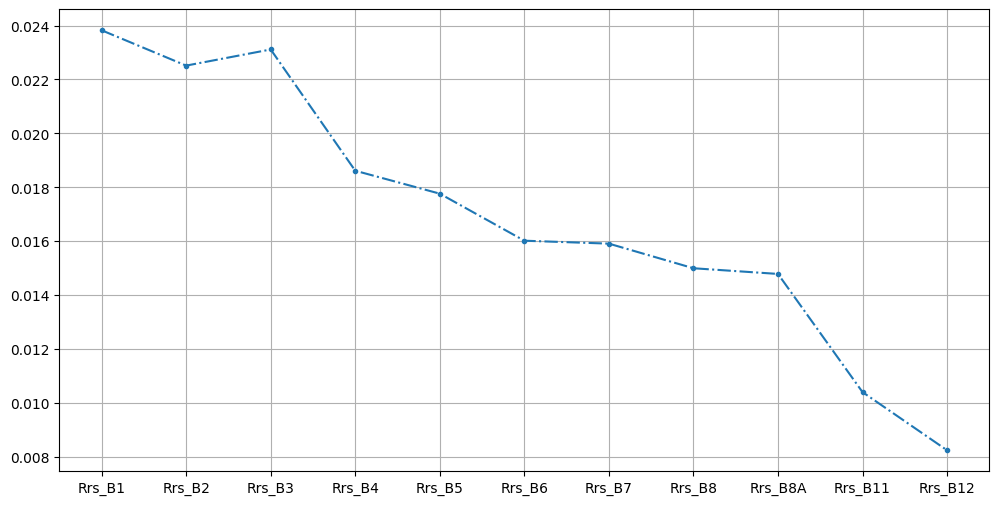

In [ ]:
import matplotlib.pyplot as plt

bands = list(rrs_values.keys())
values = list(rrs_values.values())

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(bands, values, '.-.')
ax.grid()